# Data preparation

## Data loading

In [1]:
#
# Data Loading
#

from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 133)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dataset/train')
valid_files, valid_targets = load_dataset('dataset/val')
test_files, test_targets = load_dataset('dataset/test')

# load list of categories names
category_names = [item[14:-1] for item in sorted(glob("dataset/train/*/"))]

# print statistics about the dataset
print('There are %d total categories:' % len(category_names), str(category_names))
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

Using TensorFlow backend.


There are 2 total categories: ['NORMAL', 'PNEUMONIA']
There are 5856 total images.

There are 5216 training images.
There are 16 validation images.
There are 624 test images.


## Data inspection

dataset/train/PNEUMONIA/person1493_bacteria_3896.jpeg


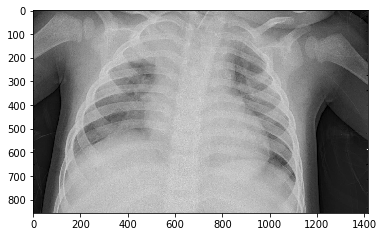

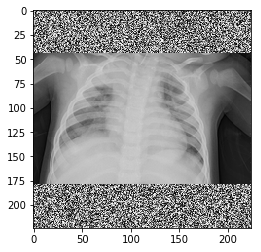

In [2]:
#
# Data Inspection
#

import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline           

from PIL import Image                  

desired_size = 224
random_img = Image.fromarray(np.random.rand(desired_size, desired_size) * 255)
random_img = random_img.convert('RGB')

def path_to_image(img_path):
    final_img = random_img.copy()  # random content image (to ensure the proper size)
    img = Image.open(img_path)
    img.thumbnail((desired_size, desired_size), Image.LANCZOS)  # rescaled image (preserves aspect ratio)
    offset = (int((desired_size - img.width)/2), int((desired_size - img.height)/2))
    final_img.paste(img, offset)
    return final_img

# display some sample images
for i in range(1):
    # original image
    print(train_files[i])
    plt.imshow(cv2.cvtColor(cv2.imread(train_files[i]), cv2.COLOR_BGR2RGB))
    plt.show()
    # show final image
    plt.imshow(cv2.cvtColor(np.asarray(path_to_image(train_files[i])), cv2.COLOR_BGR2RGB))
    plt.show()
    

## Data preprocessing

In [3]:
#
# Resizing and centering images
#
# Note: the original 16 validation images go into the training folder
#       a bigger validation dataset is created out of the training folder
#

import shutil, os, random

try:
    shutil.rmtree('dataset/resized')
except FileNotFoundError:
    pass
os.mkdir('dataset/resized')
for folder in ['train', 'valid', 'test']:
    os.mkdir('dataset/resized/' + folder)
    os.mkdir('dataset/resized/' + folder + '/NORMAL')
    os.mkdir('dataset/resized/' + folder + '/PNEUMONIA')
print('Created resized/ folder hierarchy...')

for infile in np.hstack([train_files, valid_files, test_files]):
    outfile = infile.replace('train', 'resized/train').replace('val', 'resized/train').replace('test', 'resized/test')
    path_to_image(infile).save(outfile)
print('Copied preprocessed images...')

valid_perc = 20

for category in category_names:
    train_files = glob("dataset/resized/train/" + category + "/*")
    num_valid_files = int(round(len(train_files) * valid_perc / 100))
    valid_files = random.sample(train_files, num_valid_files)
    for filename in valid_files:
        shutil.move(filename, filename.replace('train', 'valid'))
print('Rearranged train and validation datasets into {}/{} ratio...'.format(int(100-valid_perc), int(valid_perc)))


Created resized/ folder hierarchy...
Copied preprocessed images...
Rearranged train and validation datasets into 80/20 ratio...


# Transfer learning

In [4]:
# Normal or Pneumonia
NUM_CLASSES = len(category_names)

# RGB
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 15
EARLY_STOP_PATIENCE = 5

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = int(100 - valid_perc)
STEPS_PER_EPOCH_VALIDATION = int(valid_perc)

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = int(0.5*(100 - valid_perc))
BATCH_SIZE_VALIDATION = int(0.5 * valid_perc)

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [5]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout

resnet_weights_path = 'pre_trained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# dropout
model.add(Dropout(rate=0.2))

# Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [6]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'dataset/resized/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'dataset/resized/valid',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.


In [7]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best_resnet50.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [8]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("best_resnet50.hdf5")

Epoch 1/15
80/80 [==============================] - 159s 2s/step - loss: 0.2081 - acc: 0.9254 - val_loss: 0.3175 - val_acc: 0.8650
Epoch 2/15
80/80 [==============================] - 148s 2s/step - loss: 0.0987 - acc: 0.9579 - val_loss: 0.0994 - val_acc: 0.9750
Epoch 3/15
80/80 [==============================] - 148s 2s/step - loss: 0.0918 - acc: 0.9650 - val_loss: 0.4417 - val_acc: 0.8400
Epoch 4/15
80/80 [==============================] - 148s 2s/step - loss: 0.0886 - acc: 0.9670 - val_loss: 0.3106 - val_acc: 0.8750
Epoch 5/15
80/80 [==============================] - 148s 2s/step - loss: 0.0741 - acc: 0.9703 - val_loss: 0.0913 - val_acc: 0.9600
Epoch 6/15
80/80 [==============================] - 148s 2s/step - loss: 0.0735 - acc: 0.9695 - val_loss: 0.1687 - val_acc: 0.9400
Epoch 7/15
80/80 [==============================] - 148s 2s/step - loss: 0.0832 - acc: 0.9734 - val_loss: 0.0636 - val_acc: 0.9850
Epoch 8/15
80/80 [==============================] - 149s 2s/step - loss: 0.0589 - a

In [9]:
print(fit_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


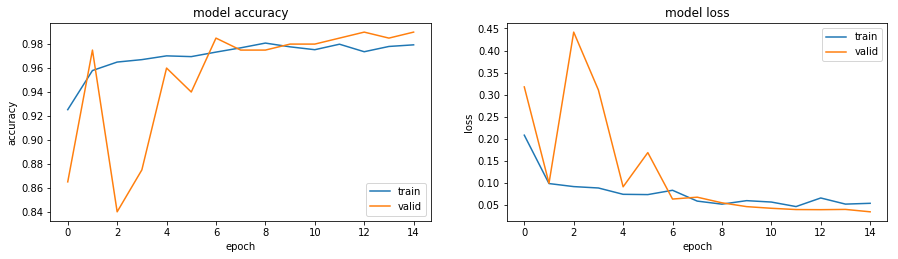

In [10]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()